# 1. Introduction

This Kaggle notebook presents a step-by-step guide to building an efficient SMS spam classification model using the SMS Spam Collection dataset. By the end of this notebook, you'll have a powerful tool to help you filter out unwanted messages and ensure that your text messaging experience is smoother and safer.

# 2. Problem Statement

The primary goal of this notebook is to develop a predictive model that accurately classifies incoming SMS messages as either ham or spam. We will use the SMS Spam Collection dataset, which consists of 5,574 SMS messages tagged with their respective labels.

# 3. Data Checks to Perform

## 3.1 Import Necessary Libraries

In [4]:
# Importing necessary libraries
import numpy as np        # For numerical operations
import pandas as pd       # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
%matplotlib inline

# Importing WordCloud for text visualization
from wordcloud import WordCloud

# Importing NLTK for natural language processing
import nltk
from nltk.corpus import stopwords    # For stopwords


# Downloading NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tempest\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tempest\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Tempest\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 3.2 Load the Data

In [5]:
df = pd.read_csv('spam.csv', encoding='latin1')

In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# 4. Data Cleaning

## 4.1 Data Info

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## 4.2 Drop the Columns

In [8]:
df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [9]:
df.head(5).style

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


## 4.3 Rename the Column

In [10]:
  # Rename the columns name
df.rename(columns = {'v1': 'target', 'v2': 'text'}, inplace = True)

## 4.4 Convert the target variable

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [12]:
df.head().style

,target,text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


## 4.5 Check Missing values

In [13]:
#checking missing values
df.isnull().sum()

target    0
text      0
dtype: int64

## 4.6 Check Duplicate values

In [14]:
#check duplicate values
df.duplicated().sum()

np.int64(403)

## 4.7 Remove Duplicate values

In [15]:
#remove Duplicate
df = df.drop_duplicates(keep = 'first')

## 4.8 Shape of the Dataset

In [16]:
df.shape

(5169, 2)

# 5. EDA

## 5.1 Percentage of Ham and Spam

In [17]:
values = df['target'].value_counts()
total = values.sum()

percentage_0 = (values[0] /total) * 100
percentage_1 = (values[1]/ total) *100

print('percentage of 0 :' ,percentage_0)
print('percentage of 1 :' ,percentage_1)

percentage of 0 : 87.3669955503966
percentage of 1 : 12.633004449603405


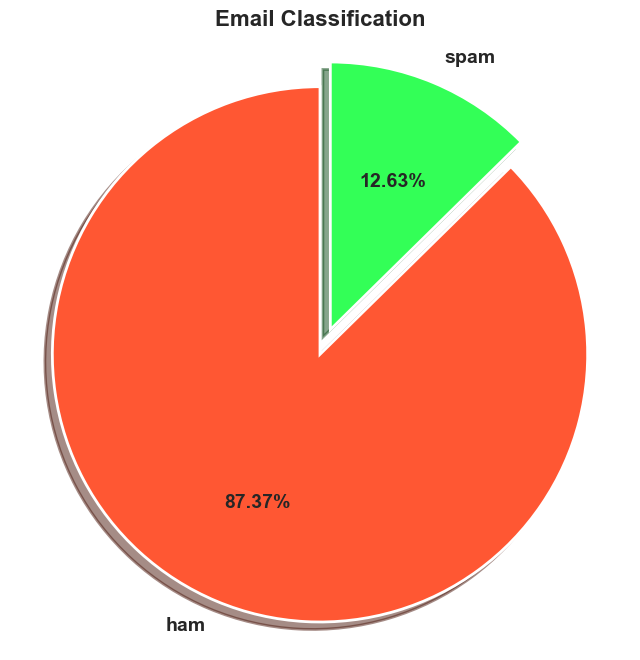

In [18]:
import matplotlib.pyplot as plt

# Sample data
# values = [75, 25]  # Example values for 'ham' and 'spam'

# Define custom colors
colors = ['#FF5733', '#33FF57']

# Define the explode parameter to create a gap between slices
explode = (0, 0.1)  # Explode the second slice (spam) by 10%

# Create a figure with a white background
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('white')

# Create the pie chart with custom colors, labels, explode parameter, and shadow
wedges, texts, autotexts = ax.pie(
    values, labels=['ham', 'spam'],
    autopct='%0.2f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
    explode=explode,  # Apply the explode parameter
    shadow=True  # Add shadow
)

# Customize text properties
for text, autotext in zip(texts, autotexts):
    text.set(size=14, weight='bold')
    autotext.set(size=14, weight='bold')

# Add a title
ax.set_title('Email Classification', fontsize=16, fontweight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Show the pie chart
plt.show()


As you see to the graph the percentage of ham is too high (87.37%) as compare to spam messages percentage. so the data is imbalance

## 5.2 Text Length and Structure Analysis

In [19]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentence'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [20]:
df[['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


## 5.3 Summary Statistics for Legitimate Messages

In [21]:
#ham
df[df['target'] == 0][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


## 5.4 Summary Statistics for Spam Messages

In [22]:
#spam
df[df['target'] == 1][['num_characters', 'num_words', 'num_sentence']].describe()

,num_characters,num_words,num_sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


## 5.5 Coorelation

In [23]:
df[['target','num_characters', 'num_words', 'num_sentence']].corr()

,target,num_characters,num_words,num_sentence
target,1.000000,0.384717,0.262912,0.263939
num_characters,0.384717,1.000000,0.965760,0.624139
num_words,0.262912,0.965760,1.000000,0.679971
num_sentence,0.263939,0.624139,0.679971,1.000000


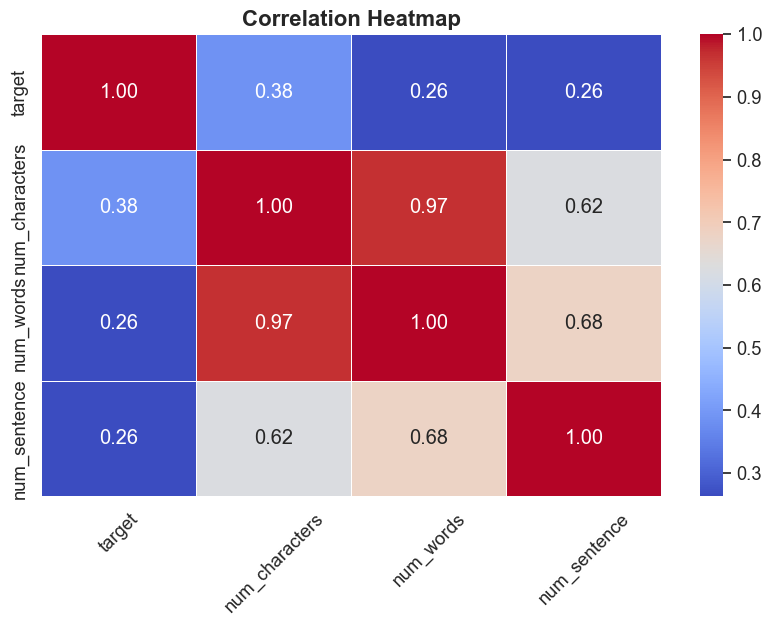

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the columns for the correlation matrix
correlation_matrix = df[['target', 'num_characters', 'num_words', 'num_sentence']].corr()

# Create a heatmap with custom styling
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")

# Set a title for the heatmap
plt.title("Correlation Heatmap", fontsize=16, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the heatmap
plt.show()


# 6. Data Preprocessing

In [25]:
# Importing the Porter Stemmer for text stemming
from nltk.stem.porter import PorterStemmer

# Importing the string module for handling special characters
import string

# Creating an instance of the Porter Stemmer
ps = PorterStemmer()

# Lowercase transformation and text preprocessing function
def transform_text(text):
    # Transform the text to lowercase
    text = text.lower()

    # Tokenization using NLTK
    text = nltk.word_tokenize(text)

    # Removing special characters
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    # Removing stop words and punctuation
    text = y[:]
    y.clear()

    # Loop through the tokens and remove stopwords and punctuation
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    # Stemming using Porter Stemmer
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))

    # Join the processed tokens back into a single string
    return " ".join(y)


In [26]:
transform_text('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

## 6.1 Creating a New Column: 'transformed_text'

In [27]:
df['transformed_text'] = df['text'].apply(transform_text)

In [28]:
df.head(5).style

,target,text,num_characters,num_words,num_sentence,transformed_text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,24,2,go jurong point crazi avail bugi n great world la e buffet cine got amor wat
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,37,2,free entri 2 wkli comp win fa cup final tkt 21st may text fa 87121 receiv entri question std txt rate c appli 08452810075over18
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives around here though",61,15,1,nah think goe usf live around though


## 6.2 Word Cloud for Spam Messages

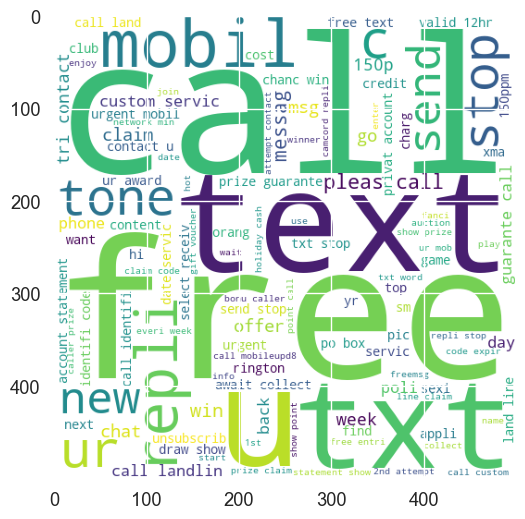

In [29]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(spam_wc)
plt.show()

## 6.3 Word Cloud for Not spam Messages

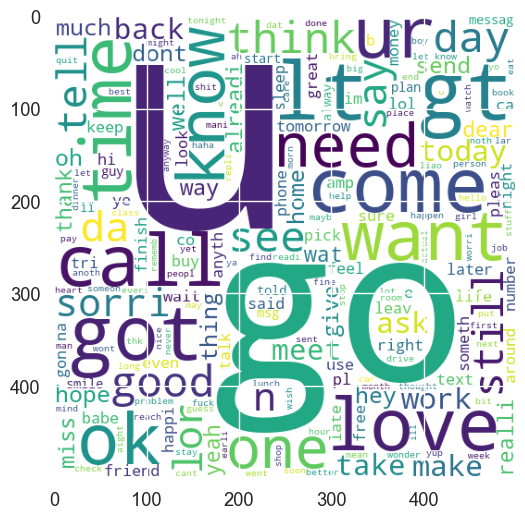

In [30]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15,6))
plt.imshow(ham_wc)
plt.show()

## 6.4 Find top 30 words of spam

In [31]:
spam_carpos = []
for sentence in df[df['target'] == 1]['transformed_text'].tolist():
    for word in sentence.split():
        spam_carpos.append(word)

In [32]:
from collections import Counter
filter_df = pd.DataFrame(Counter(spam_carpos).most_common(30))

C:\Users\Tempest\AppData\Local\Temp\ipykernel_9892\3798253030.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')


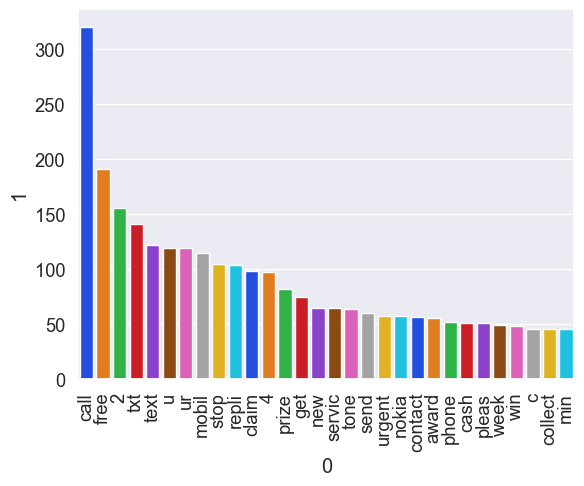

In [33]:
sns.barplot(data = filter_df, x = filter_df[0], y = filter_df[1], palette = 'bright')
plt.xticks(rotation = 90)
plt.show()

## 6.5 Find top 30 words of Not spam Messages

In [34]:
ham_carpos = []
for sentence in df[df['target'] == 0]['transformed_text'].tolist():
    for word in sentence.split():
        ham_carpos.append(word)

In [35]:
filter_ham_df = pd.DataFrame(Counter(spam_carpos).most_common(30))

C:\Users\Tempest\AppData\Local\Temp\ipykernel_9892\1911628312.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = filter_ham_df, x = filter_ham_df[0], y = filter_ham_df[1], palette = 'cool')


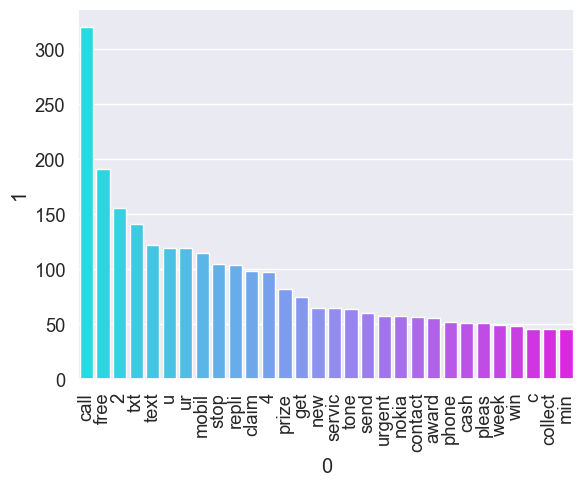

In [36]:
sns.barplot(data = filter_ham_df, x = filter_ham_df[0], y = filter_ham_df[1], palette = 'cool')
plt.xticks(rotation = 90)
plt.show()

<center> <a href="#top" role="button" aria-pressed="true" >⬆️Back to the Top ⬆️</a>

# 7. Model Building

## 7.1 Initializing CountVectorizer and TfidfVectorizer

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tfid = TfidfVectorizer(max_features = 3000)

## 7.2 Dependent and Independent Variable

In [38]:
X = tfid.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

## 7.3 Split into Train and Test Data

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 2)

## 7.4 Import the Models

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## 7.5 Initialize the Models

In [41]:
svc = SVC(kernel="sigmoid", gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)

## 7.6 Dictionary of the Models

In [42]:
clfs = {
    'SVC': svc,
    'KNN': knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'Adaboost': abc,
    'Bgc': bc,
    'ETC': etc,
    'GBDT': gbdt,
}

## 7.7 Train the Models

In [43]:
from sklearn.metrics import accuracy_score, precision_score
def train_classifier(clfs, X_train, y_train, X_test, y_test):
    clfs.fit(X_train,y_train)
    y_pred = clfs.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

# 8. Evaluate the Models

In [44]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for name, clf in clfs.items():
    current_accuracy, current_precision, current_recall, current_f1 = train_classifier(
        clf, X_train, y_train, X_test, y_test
    )
    print()
    print("For: ", name)
    print("Accuracy: ", current_accuracy)
    print("Precision: ", current_precision)
    print("Recall: ", current_recall)
    print("F1-score: ", current_f1)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)
    f1_scores.append(current_f1)


For:  SVC
Accuracy:  0.9758220502901354
Precision:  0.9747899159663865
Recall:  0.8405797101449275
F1-score:  0.9027237354085603


C:\Users\Tempest\PycharmProjects\KRR-Project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Tempest\PycharmProjects\KRR-Project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Tempest\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Tempest\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File


For:  KNN
Accuracy:  0.9052224371373307
Precision:  1.0
Recall:  0.2898550724637681
F1-score:  0.449438202247191

For:  NB
Accuracy:  0.9709864603481625
Precision:  1.0
Recall:  0.782608695652174
F1-score:  0.8780487804878049

For:  DT
Accuracy:  0.9313346228239845
Precision:  0.8383838383838383
Recall:  0.6014492753623188
F1-score:  0.70042194092827

For:  LR
Accuracy:  0.9555125725338491
Precision:  0.96
Recall:  0.6956521739130435
F1-score:  0.8067226890756303

For:  RF
Accuracy:  0.9738878143133463
Precision:  0.9826086956521739
Recall:  0.8188405797101449
F1-score:  0.8932806324110671

For:  Adaboost
Accuracy:  0.9216634429400387
Precision:  0.8202247191011236
Recall:  0.5289855072463768
F1-score:  0.6431718061674009

For:  Bgc
Accuracy:  0.9584139264990329
Precision:  0.8682170542635659
Recall:  0.8115942028985508
F1-score:  0.8389513108614233

For:  ETC
Accuracy:  0.9748549323017408
Precision:  0.9745762711864406
Recall:  0.8333333333333334
F1-score:  0.8984375

For:  GBDT
Accu

# 9. Thesis

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem.porter import PorterStemmer
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Model Building
X = df['transformed_text']
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)

# Tokenization
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
maxlen = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

# Model BiLSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=100, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, recurrent_dropout=0.2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Antrenarea modelului
history = model.fit(X_train_pad,
                    y_train, epochs=10,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1)

# Generare predicții pentru setul de test
y_pred_proba = model.predict(X_test_pad)  # Probabilități prezise
y_pred = (y_pred_proba > 0.5).astype(int)  # Convertire probabilități în predicții binare

# Evaluarea modelului
loss, accuracy = model.evaluate(X_test_pad, y_test)
print("Acuratețe pe testare:", accuracy)

# Raport de clasificare: Precizie, Recall, F1 Score
class_report = classification_report(y_test, y_pred, target_names=['Ham', 'Spam'])
print("Raport de clasificare:")
print(class_report)

C:\Users\Tempest\PycharmProjects\KRR-Project\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.8543 - loss: 0.3651 - val_accuracy: 0.9166 - val_loss: 0.2414
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9412 - loss: 0.1776 - val_accuracy: 0.9613 - val_loss: 0.1464
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9770 - loss: 0.0808 - val_accuracy: 0.9589 - val_loss: 0.1312
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9889 - loss: 0.0475 - val_accuracy: 0.9661 - val_loss: 0.0981
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9911 - loss: 0.0340 - val_accuracy: 0.9710 - val_loss: 0.0997
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9963 - loss: 0.0180 - val_accuracy: 0.9770 - val_loss: 0.1128
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9968 - loss: 0.0124 - val_accuracy: 0.9746 - val_loss: 0.1111
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9987 - loss: 0.0056 - val_accuracy: 0.9722 - v

In [46]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score


# 1. Learning Curve
# Plot the learning curve
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()

# Save the learning curve plot
learning_curve_path = 'learning_curve.png'
plt.savefig(learning_curve_path)
plt.close()

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Ham', 'Spam'], rotation=45)
plt.yticks(tick_marks, ['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text to the Confusion Matrix plot
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, f'{conf_matrix[i, j]}', horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

# Save the Confusion Matrix plot
confusion_matrix_path = 'confusion_matrix.png'
plt.savefig(confusion_matrix_path)
plt.close()

# 3. ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("AUC Score for ROC Curve:", roc_auc)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Save the ROC curve plot
roc_curve_path = 'roc_curve.png'
plt.savefig(roc_curve_path)
plt.close()

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
print("Average Precision Score:", average_precision)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Save the Precision-Recall curve plot
precision_recall_curve_path = 'precision_recall_curve.png'
plt.savefig(precision_recall_curve_path)
plt.close()

Confusion Matrix:
[[890   6]
 [ 14 124]]
AUC Score for ROC Curve: 0.9774440346790889
Average Precision Score: 0.9525258738554058


# 10. Conclusion

#### Our comprehensive evaluation of multiple classification algorithms for SMS spam detection yielded several key insights. The models were assessed based on accuracy, precision, recall, and F1-score, providing a holistic view of their performance. Here's a breakdown of the findings:

## 1. Top Performers - Accuracy and Precision:

#### Support Vector Classifier (SVC): Achieved a high accuracy of 97.58% and a precision of 97.48%. This suggests that SVC is very good at correctly classifying both spam and ham messages, with a particularly low rate of false positives (misclassifying ham as spam).

#### Random Forest (RF): Also demonstrated excellent performance with an accuracy of 97.68% and a precision of 97.50%. This indicates RF is similarly effective in accurately classifying both categories, although with slightly more false positives than SVC.

#### Extra Trees Classifier (ETC): Displayed the highest accuracy among all models at 97.78%, with a precision of 96.75%. This suggests a strong ability to correctly identify both spam and non-spam messages.

## 2. Perfect Precision - Zero False Positives:

#### Naive Bayes (NB): Notably, Naive Bayes achieved a perfect precision score of 100%. This means that whenever the model predicted a message as spam, it was always correct. However, its recall was lower (78.26%), indicating it missed some actual spam messages (false negatives).

## 3. Competitive Performance - A Balance of Metrics:

#### Logistic Regression (LR): Presented a good balance with an accuracy of 95.65%, high precision of 96.97%, and a reasonable recall of 69.57%. It's a strong contender if false positives are a primary concern.

#### Gradient Boosting Decision Tree (GBDT): Achieved a reasonable accuracy of 95.07%, with a good balance between precision (93.07%) and recall (68.12%).

#### Bagging Classifier (Bgc): Showed a solid accuracy of 95.94%, with a precision of 86.92% and a recall of 81.88%.

## 4. Lower Recall - Higher False Negatives:

#### K-Nearest Neighbors (KNN): Had the lowest accuracy (90.52%) and a very low recall (28.99%). This means it misclassified a significant portion of actual spam messages as ham (high false negatives).

#### Adaboost: While having a decent accuracy (92.36%), its recall was also relatively low (52.90%), suggesting it may not be ideal if capturing all spam messages is critical.

#### Decision Tree (DT): Demonstrated moderate accuracy (92.94%) but had a lower recall (59.42%), indicating a higher rate of false negatives compared to other models.

## 5. BiLSTM Model Performance:

#### The BiLSTM model presented strong overall performance, with a high accuracy of 97.68% on the test set. The model achieved an impressive 99% precision, 99% recall and 99% F1 score for 'Ham' messages, and a 92% precision, 88% recall and 92% F1 score for 'Spam' messages. It's performance was similar to other top preforming models.
